In [2]:
import os
import shutil
from glob import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score
import tensorflow.keras.backend as K

from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
import datetime
from tensorflow.keras.models import load_model


In [3]:


# Ruta de la carpeta de imágenes originales
original_images_path = "A. Segmentation/1. Original Images/a. Training Set/"

# Obtener todas las imágenes de la carpeta
image_files = sorted(os.listdir(original_images_path))  # Ordenar por nombre

# Crear lista para almacenar las imágenes procesadas
images = []

for img_file in image_files:
    # Verificar si el nombre del archivo contiene 'IDRiD_43_HE'
    if 'IDRiD_43' not in img_file:
        # Cargar la imagen original
        img_path = os.path.join(original_images_path, img_file)
        img = cv2.imread(img_path)  # Leer imagen
        img_resized = cv2.resize(img, (256, 256))  # Redimensionar a 128x128
        img_normalized = img_resized.astype('float32') / 255.0  # Normalizar imagen (valores entre 0 y 1)

        # Almacenar la imagen procesada
        images.append(img_normalized)

# Convertir a un array de numpy
images = np.array(images)

# Imprimir la forma de las imágenes para verificar
print(f"Forma de las imágenes procesadas: {images.shape}")  # Debería ser (53, 128, 128, 3) si se eliminó una imagen

Forma de las imágenes procesadas: (53, 256, 256, 3)


In [4]:


# Ruta de la carpeta de las máscaras de Hard Exudates
hard_exudates_path = "A. Segmentation/2. All Segmentation Groundtruths/a. Training Set/2. Hemorrhages/"

# Obtener todas las máscaras de la carpeta de Hard Exudates
mask_files = sorted(os.listdir(hard_exudates_path))  # Ordenar por nombre
masks = []

for mask_file in mask_files:
    # Cargar la máscara
    mask_path_full = os.path.join(hard_exudates_path, mask_file)
    mask = cv2.imread(mask_path_full, cv2.IMREAD_GRAYSCALE)  # Leer imagen en escala de grises

  

    # Redimensionar la máscara a 128x128
    mask_resized = cv2.resize(mask, (256, 256))  # Redimensionar a 128x128

    # Normalizar dividiendo entre 76 si los valores no están en el rango [0, 1]
    mask_resized = mask_resized.astype('float32') / 76.0  # Normalizar entre 0 y 1

    # Añadir un canal adicional
    mask_resized = np.expand_dims(mask_resized, axis=-1)  # Añadir el canal adicional

    # Almacenar la máscara procesada
    masks.append(mask_resized)

# Convertir a un array de numpy
processed_masks = np.array(masks)

# Imprimir la forma de las máscaras procesadas para verificar
print(f"Forma de las máscaras procesadas de Hemorraghes con canal añadido: {processed_masks.shape}")


Forma de las máscaras procesadas de Hemorraghes con canal añadido: (53, 256, 256, 1)


In [5]:
x_train=images      
y_train=processed_masks
# Imprimir las formas de los conjuntos de datos para verificar
print(f"Forma de x_train: {x_train.shape}")
print(f"Forma de y_train: {y_train.shape}")

Forma de x_train: (53, 256, 256, 3)
Forma de y_train: (53, 256, 256, 1)


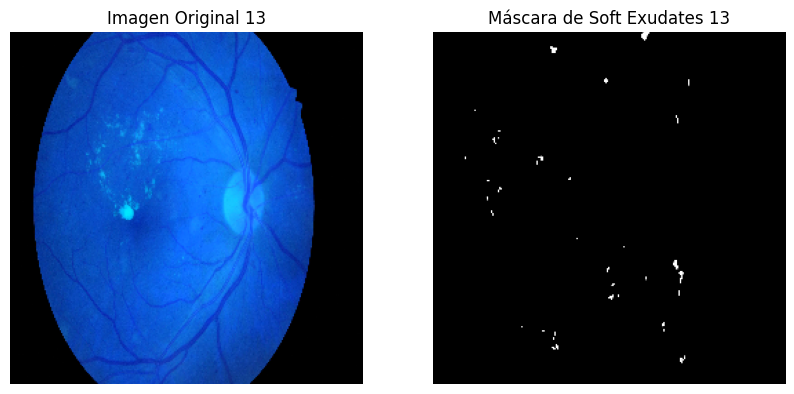

In [6]:

# Supongamos que tienes la lista de imágenes y máscaras procesadas
# Aquí seleccionamos una imagen específica (por ejemplo, la primera imagen en la lista)

index = 12 # Cambia este índice para seleccionar la imagen que deseas visualizar

# Selecciona la imagen y su máscara correspondiente
image_to_show = x_train[index]
mask_to_show = y_train[index]

# Eliminar el canal extra de la máscara
mask_to_show = mask_to_show.squeeze(axis=-1)  # Eliminar el canal extra

# Crear una figura con 1 fila y 2 columnas para mostrar la imagen y la máscara
plt.figure(figsize=(10, 5))

# Mostrar la imagen
plt.subplot(1, 2, 1)  # Fila 1, Columna 1
plt.imshow(image_to_show)
plt.title(f"Imagen Original {index + 1}")
plt.axis('off')  # No mostrar los ejes

# Mostrar la máscara
plt.subplot(1, 2, 2)  # Fila 1, Columna 2
plt.imshow(mask_to_show, cmap='gray')  # Mostrar en escala de grises
plt.title(f"Máscara de Soft Exudates {index + 1}")
plt.axis('off')  # No mostrar los ejes

# Mostrar la figura
plt.show()


In [7]:


def iou_coef(y_true, y_pred, threshold=0.5):
    """
    Función para calcular el IoU (Intersection over Union) para segmentación binaria.

    Parámetros:
    y_true: La máscara verdadera (ground truth), un tensor de forma (batch_size, height, width, 1)
    y_pred: La predicción del modelo, un tensor de forma (batch_size, height, width, 1)
    threshold: El umbral para convertir la probabilidad de la predicción en una máscara binaria (por defecto 0.5)

    Retorna:
    El valor del IoU.
    """
    
    # Aplicar umbral para obtener predicción binaria
    y_pred = K.cast(K.greater(y_pred, threshold), K.floatx())

    # Calcular la intersección y la unión
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred) - intersection

    # Calcular el IoU
    iou = intersection / (union + K.epsilon())  # Usamos K.epsilon() para evitar la división por cero

    return iou



def dice_coef(y_true, y_pred, smooth=10):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)



from tensorflow.keras.metrics import AUC

def auprc(y_true, y_pred):
    """
    Calcula el área bajo la curva Precision-Recall (AUPRC).
    
    Parámetros:
    y_true: Tensor de la máscara verdadera (ground truth).
    y_pred: Tensor de la predicción del modelo.
    
    Retorna:
    AUPRC como métrica de Keras.
    """
    return AUC(curve="PR", name="AUPRC")(y_true, y_pred)

# Función para calcular el Dice Coefficient
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)


In [9]:





# Función para construir la U-Net modificada
def modified_unet(input_size=(256, 256, 3), num_max_pooling=4):
    # Entrada
    inputs = Input(input_size)
    
    # Contracción (Encoder)
    conv1 = Conv2D(64, 3, activation="relu", padding="same")(inputs)
    conv1 = Conv2D(64, 3, activation="relu", padding="same")(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(128, 3, activation="relu", padding="same")(pool1)
    conv2 = Conv2D(128, 3, activation="relu", padding="same")(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(256, 3, activation="relu", padding="same")(pool2)
    conv3 = Conv2D(256, 3, activation="relu", padding="same")(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = Conv2D(512, 3, activation="relu", padding="same")(pool3)
    conv4 = Conv2D(512, 3, activation="relu", padding="same")(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)
    
    # Fondo (Bottom)
    conv5 = Conv2D(1024, 3, activation="relu", padding="same")(pool4)
    conv5 = Conv2D(1024, 3, activation="relu", padding="same")(conv5)
    drop5 = Dropout(0.5)(conv5)
    
    # Expansión (Decoder)
    up6 = Conv2DTranspose(512, 2, strides=(2, 2), padding="same")(drop5)
    merge6 = concatenate([drop4, up6], axis=3)
    conv6 = Conv2D(512, 3, activation="relu", padding="same")(merge6)
    conv6 = Conv2D(512, 3, activation="relu", padding="same")(conv6)
    
    up7 = Conv2DTranspose(256, 2, strides=(2, 2), padding="same")(conv6)
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(256, 3, activation="relu", padding="same")(merge7)
    conv7 = Conv2D(256, 3, activation="relu", padding="same")(conv7)
    
    up8 = Conv2DTranspose(128, 2, strides=(2, 2), padding="same")(conv7)
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(128, 3, activation="relu", padding="same")(merge8)
    conv8 = Conv2D(128, 3, activation="relu", padding="same")(conv8)
    
    up9 = Conv2DTranspose(64, 2, strides=(2, 2), padding="same")(conv8)
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(64, 3, activation="relu", padding="same")(merge9)
    conv9 = Conv2D(64, 3, activation="relu", padding="same")(conv9)
    
    # Salida
    outputs = Conv2D(1, 1, activation="sigmoid")(conv9)  # 1 canal para la máscara binaria
    
    # Crear el modelo
    model = Model(inputs, outputs)
    
    return model

# Construir el modelo
num_max_pooling = 4  # Para SE (Soft Exudates)
model = modified_unet(input_size=(256, 256, 3), num_max_pooling=num_max_pooling)

# Compilar el modelo
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy", dice_coef]
)

# Definir callbacks
log_dir = "logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint("best_unet_modelHE2.h5", save_best_only=True, monitor="val_loss", mode="min")
tensorboard = TensorBoard(log_dir=log_dir, histogram_freq=1)

callbacks = [early_stopping, checkpoint, tensorboard]

# Resumen del modelo
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 32, 32,    │          0 │ conv2d_7[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 16,    │          0 │ dropout[0][0]     │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 16, 16,    │  4,719,616 │ max_pooling2d_3[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 16, 16,    │  9,438,208 │ conv2d_8[0][0]    │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 16, 16,    │          0 │ conv2d_9[0][0]  

 Total params: 31,031,745 (118.38 MB)

 Trainable params: 31,031,745 (118.38 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
history = model.fit(x_train, y_train, validation_split=0.2, epochs=50, batch_size=8, callbacks=callbacks)


Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 43s/step - accuracy: 0.4982 - dice_coef: 0.0291 - loss: 0.6919 

6/6 ━━━━━━━━━━━━━━━━━━━━ 412s 64s/step - accuracy: 0.5310 - dice_coef: 0.0280 - loss: 0.6907 - val_accuracy: 0.9934 - val_dice_coef: 0.0102 - val_loss: 0.6510
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 46s/step - accuracy: 0.9896 - dice_coef: 0.0188 - loss: 0.6386 

6/6 ━━━━━━━━━━━━━━━━━━━━ 381s 65s/step - accuracy: 0.9895 - dice_coef: 0.0189 - loss: 0.6372 - val_accuracy: 0.9937 - val_dice_coef: 0.0097 - val_loss: 0.5699
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 45s/step - accuracy: 0.9897 - dice_coef: 0.0176 - loss: 0.5139 

6/6 ━━━━━━━━━━━━━━━━━━━━ 356s 59s/step - accuracy: 0.9896 - dice_coef: 0.0175 - loss: 0.5051 - val_accuracy: 0.9937 - val_dice_coef: 5.2727e-04 - val_loss: 0.1186
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 291s 48s/step - accuracy: 0.9878 - dice_coef: 5.9837e-04 - loss: 0.2220 - val_accuracy: 0.9937 - val_dice_coef: 9.8272e-04 - val_loss: 0.1312
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 44s/step - accuracy: 0.9847 - dice_coef: 0.0065 - loss: 0.1615 

6/6 ━━━━━━━━━━━━━━━━━━━━ 351s 61s/step - accuracy: 0.9852 - dice_coef: 0.0062 - loss: 0.1592 - val_accuracy: 0.9937 - val_dice_coef: 6.5345e-04 - val_loss: 0.1074
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 49s/step - accuracy: 0.9847 - dice_coef: 0.0047 - loss: 0.1421 

6/6 ━━━━━━━━━━━━━━━━━━━━ 374s 66s/step - accuracy: 0.9852 - dice_coef: 0.0044 - loss: 0.1387 - val_accuracy: 0.9937 - val_dice_coef: 7.3324e-04 - val_loss: 0.0828
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 36s/step - accuracy: 0.9902 - dice_coef: 0.0026 - loss: 0.0934   

6/6 ━━━━━━━━━━━━━━━━━━━━ 314s 54s/step - accuracy: 0.9900 - dice_coef: 0.0029 - loss: 0.0945 - val_accuracy: 0.9937 - val_dice_coef: 0.0030 - val_loss: 0.0804
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 45s/step - accuracy: 0.9885 - dice_coef: 0.0074 - loss: 0.0843 

6/6 ━━━━━━━━━━━━━━━━━━━━ 370s 64s/step - accuracy: 0.9885 - dice_coef: 0.0074 - loss: 0.0836 - val_accuracy: 0.9937 - val_dice_coef: 0.0042 - val_loss: 0.0486
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 289s 49s/step - accuracy: 0.9901 - dice_coef: 0.0084 - loss: 0.0616 - val_accuracy: 0.9937 - val_dice_coef: 0.0079 - val_loss: 0.0624
Epoch 10/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 54s/step - accuracy: 0.9843 - dice_coef: 0.0250 - loss: 0.0817  

6/6 ━━━━━━━━━━━━━━━━━━━━ 402s 69s/step - accuracy: 0.9849 - dice_coef: 0.0239 - loss: 0.0795 - val_accuracy: 0.9937 - val_dice_coef: 0.0055 - val_loss: 0.0410
Epoch 11/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 327s 55s/step - accuracy: 0.9915 - dice_coef: 0.0080 - loss: 0.0513 - val_accuracy: 0.9937 - val_dice_coef: 0.0085 - val_loss: 0.0463
Epoch 12/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 335s 56s/step - accuracy: 0.9895 - dice_coef: 0.0205 - loss: 0.0594 - val_accuracy: 0.9937 - val_dice_coef: 0.0084 - val_loss: 0.0455
Epoch 13/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 42s/step - accuracy: 0.9875 - dice_coef: 0.0168 - loss: 0.0641 

6/6 ━━━━━━━━━━━━━━━━━━━━ 324s 55s/step - accuracy: 0.9876 - dice_coef: 0.0164 - loss: 0.0634 - val_accuracy: 0.9937 - val_dice_coef: 0.0055 - val_loss: 0.0388
Epoch 14/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 299s 50s/step - accuracy: 0.9886 - dice_coef: 0.0115 - loss: 0.0617 - val_accuracy: 0.9937 - val_dice_coef: 0.0089 - val_loss: 0.0415
Epoch 15/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 345s 60s/step - accuracy: 0.9878 - dice_coef: 0.0219 - loss: 0.0601 - val_accuracy: 0.9937 - val_dice_coef: 0.0093 - val_loss: 0.0410
Epoch 16/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 41s/step - accuracy: 0.9897 - dice_coef: 0.0157 - loss: 0.0548 

6/6 ━━━━━━━━━━━━━━━━━━━━ 336s 58s/step - accuracy: 0.9896 - dice_coef: 0.0159 - loss: 0.0553 - val_accuracy: 0.9937 - val_dice_coef: 0.0086 - val_loss: 0.0385
Epoch 17/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 423s 73s/step - accuracy: 0.9852 - dice_coef: 0.0280 - loss: 0.0736 - val_accuracy: 0.9937 - val_dice_coef: 0.0106 - val_loss: 0.0525
Epoch 18/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 58s/step - accuracy: 0.9897 - dice_coef: 0.0198 - loss: 0.0577  

6/6 ━━━━━━━━━━━━━━━━━━━━ 468s 82s/step - accuracy: 0.9896 - dice_coef: 0.0197 - loss: 0.0578 - val_accuracy: 0.9937 - val_dice_coef: 0.0062 - val_loss: 0.0375
Epoch 19/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 56s/step - accuracy: 0.9875 - dice_coef: 0.0127 - loss: 0.0652  

6/6 ━━━━━━━━━━━━━━━━━━━━ 428s 74s/step - accuracy: 0.9877 - dice_coef: 0.0125 - loss: 0.0645 - val_accuracy: 0.9937 - val_dice_coef: 0.0081 - val_loss: 0.0371
Epoch 20/50
5/6 ━━━━━━━━━━━━━━━━━━━━ 3:50 231s/step - accuracy: 0.9834 - dice_coef: 0.0278 - loss: 0.0752

AbortedError: Graph execution error:

Detected at node StatefulPartitionedCall/functional_2_1/conv2d_transpose_7_1/conv_transpose defined at (most recent call last):
<stack traces unavailable>
Operation received an exception:Status: 1, message: could not create a primitive, in file tensorflow/core/kernels/mkl/mkl_conv_grad_input_ops.cc:546
	 [[{{node StatefulPartitionedCall/functional_2_1/conv2d_transpose_7_1/conv_transpose}}]] [Op:__inference_multi_step_on_iterator_18672]

In [13]:

tf.config.run_functions_eagerly(True)



model = load_model("best_unet_modelHE2.h5", custom_objects={"dice_coef": dice_coef}, compile=False)
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy", dice_coef])


In [14]:
history = model.fit(x_train, y_train, validation_split=0.2, epochs=30, batch_size=4, callbacks=callbacks)


c:\Users\Usuario\OneDrive\Documentos\Udea\Udea2024-2\AprendizajeEstadistico\venv\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22s/step - accuracy: 0.9911 - dice_coef: 0.0110 - loss: 11.1955 

11/11 ━━━━━━━━━━━━━━━━━━━━ 316s 29s/step - accuracy: 0.9909 - dice_coef: 0.0115 - loss: 10.7638 - val_accuracy: 0.9937 - val_dice_coef: 0.0083 - val_loss: 0.3016
Epoch 2/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22s/step - accuracy: 0.9858 - dice_coef: 0.0056 - loss: 0.2881 

11/11 ━━━━━━━━━━━━━━━━━━━━ 319s 29s/step - accuracy: 0.9860 - dice_coef: 0.0056 - loss: 0.2824 - val_accuracy: 0.9937 - val_dice_coef: 0.0053 - val_loss: 0.1393
Epoch 3/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22s/step - accuracy: 0.9874 - dice_coef: 0.0066 - loss: 0.1218 

11/11 ━━━━━━━━━━━━━━━━━━━━ 316s 29s/step - accuracy: 0.9875 - dice_coef: 0.0066 - loss: 0.1217 - val_accuracy: 0.9937 - val_dice_coef: 0.0048 - val_loss: 0.0568
Epoch 4/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 300s 27s/step - accuracy: 0.9906 - dice_coef: 0.0075 - loss: 0.0720 - val_accuracy: 0.9937 - val_dice_coef: 0.0089 - val_loss: 0.1683
Epoch 5/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 303s 28s/step - accuracy: 0.9919 - dice_coef: 0.0088 - loss: 0.0927 - val_accuracy: 0.9937 - val_dice_coef: 0.0087 - val_loss: 0.1318
Epoch 6/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21s/step - accuracy: 0.9887 - dice_coef: 0.0167 - loss: 0.1370 

11/11 ━━━━━━━━━━━━━━━━━━━━ 299s 27s/step - accuracy: 0.9886 - dice_coef: 0.0165 - loss: 0.1364 - val_accuracy: 0.9937 - val_dice_coef: 0.0064 - val_loss: 0.0415
Epoch 7/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 302s 27s/step - accuracy: 0.9860 - dice_coef: 0.0144 - loss: 0.1020 - val_accuracy: 0.9937 - val_dice_coef: 0.0030 - val_loss: 0.0450
Epoch 8/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 306s 28s/step - accuracy: 0.9887 - dice_coef: 0.0048 - loss: 0.0971 - val_accuracy: 0.9937 - val_dice_coef: 0.0077 - val_loss: 0.0629
Epoch 9/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 327s 29s/step - accuracy: 0.9892 - dice_coef: 0.0144 - loss: 0.0665 - val_accuracy: 0.9937 - val_dice_coef: 0.0054 - val_loss: 0.0716
Epoch 10/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 297s 27s/step - accuracy: 0.9863 - dice_coef: 0.0203 - loss: 0.0753 - val_accuracy: 0.9937 - val_dice_coef: 0.0074 - val_loss: 0.0466
Epoch 11/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22s/step - accuracy: 0.9890 - dice_coef: 0.0155 - loss: 0.0602 

11/11 ━━━━━━━━━━━━━━━━━━━━ 309s 28s/step - accuracy: 0.9890 - dice_coef: 0.0155 - loss: 0.0603 - val_accuracy: 0.9937 - val_dice_coef: 0.0080 - val_loss: 0.0399
Epoch 12/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22s/step - accuracy: 0.9887 - dice_coef: 0.0145 - loss: 0.0590 

11/11 ━━━━━━━━━━━━━━━━━━━━ 314s 29s/step - accuracy: 0.9887 - dice_coef: 0.0146 - loss: 0.0590 - val_accuracy: 0.9937 - val_dice_coef: 0.0096 - val_loss: 0.0375
Epoch 13/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 300s 27s/step - accuracy: 0.9894 - dice_coef: 0.0146 - loss: 0.0569 - val_accuracy: 0.9937 - val_dice_coef: 0.0094 - val_loss: 0.0393
Epoch 14/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 298s 27s/step - accuracy: 0.9892 - dice_coef: 0.0165 - loss: 0.0565 - val_accuracy: 0.9937 - val_dice_coef: 0.0083 - val_loss: 0.0430
Epoch 15/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21s/step - accuracy: 0.9870 - dice_coef: 0.0208 - loss: 0.0620 

11/11 ━━━━━━━━━━━━━━━━━━━━ 303s 28s/step - accuracy: 0.9871 - dice_coef: 0.0206 - loss: 0.0615 - val_accuracy: 0.9937 - val_dice_coef: 0.0102 - val_loss: 0.0374
Epoch 16/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 292s 26s/step - accuracy: 0.9884 - dice_coef: 0.0174 - loss: 0.0564 - val_accuracy: 0.9937 - val_dice_coef: 0.0087 - val_loss: 0.0396
Epoch 17/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 330s 31s/step - accuracy: 0.9897 - dice_coef: 0.0164 - loss: 0.0515 - val_accuracy: 0.9937 - val_dice_coef: 0.0094 - val_loss: 0.0398
Epoch 18/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23s/step - accuracy: 0.9816 - dice_coef: 0.0311 - loss: 0.0768 

11/11 ━━━━━━━━━━━━━━━━━━━━ 327s 29s/step - accuracy: 0.9822 - dice_coef: 0.0302 - loss: 0.0751 - val_accuracy: 0.9937 - val_dice_coef: 0.0107 - val_loss: 0.0361
Epoch 19/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21s/step - accuracy: 0.9872 - dice_coef: 0.0211 - loss: 0.0588 

11/11 ━━━━━━━━━━━━━━━━━━━━ 301s 28s/step - accuracy: 0.9873 - dice_coef: 0.0209 - loss: 0.0585 - val_accuracy: 0.9937 - val_dice_coef: 0.0106 - val_loss: 0.0357
Epoch 20/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 306s 28s/step - accuracy: 0.9887 - dice_coef: 0.0190 - loss: 0.0553 - val_accuracy: 0.9937 - val_dice_coef: 0.0106 - val_loss: 0.0378
Epoch 21/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 304s 28s/step - accuracy: 0.9910 - dice_coef: 0.0159 - loss: 0.0452 - val_accuracy: 0.9937 - val_dice_coef: 0.0103 - val_loss: 0.0375
Epoch 22/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 309s 27s/step - accuracy: 0.9887 - dice_coef: 0.0215 - loss: 0.0529 - val_accuracy: 0.9937 - val_dice_coef: 0.0114 - val_loss: 0.0368
Epoch 23/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 306s 28s/step - accuracy: 0.9874 - dice_coef: 0.0237 - loss: 0.0583 - val_accuracy: 0.9937 - val_dice_coef: 0.0107 - val_loss: 0.0368
Epoch 24/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 306s 28s/step - accuracy: 0.9929 - dice_coef: 0.0132 - loss: 0.0381 - val_accuracy: 0.9937 - val_dice_coef: 

In [18]:

# Procesamiento de imágenes de prueba
def load_and_process_images(image_dir, mask_dir, image_size=(256, 256)):
    image_files = sorted(os.listdir(image_dir))
    mask_files = sorted(os.listdir(mask_dir))
    
    x_test = []
    y_test = []
    
    for img_file, mask_file in zip(image_files, mask_files):
        img_path = os.path.join(image_dir, img_file)
        mask_path = os.path.join(mask_dir, mask_file)
        
        img = cv2.imread(img_path)
        img = cv2.resize(img, image_size)
        img = img / 255.0  # Normalización
        
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, image_size)
        mask = np.expand_dims(mask, axis=-1)  # Añadir canal
        mask = mask / 76.0  # Normalización específica
        
        x_test.append(img)
        y_test.append(mask)
    
    return np.array(x_test), np.array(y_test)

# Rutas de test
test_images_path = "A. Segmentation/1. Original Images/b. Testing Set/"
test_masks_path = "A. Segmentation/2. All Segmentation Groundtruths/b. Testing Set/2. Haemorrhages"

# Cargar y procesar los datos de prueba
x_test, y_test = load_and_process_images(test_images_path, test_masks_path)

print("Forma de x_test:", x_test.shape)
print("Forma de y_test:", y_test.shape)

Forma de x_test: (27, 256, 256, 3)
Forma de y_test: (27, 256, 256, 1)


In [53]:
import gc

gc.collect()
K.clear_session()

In [19]:

# Cargar el modelo desde el checkpoint
model = load_model("best_unet_modelHE2.h5", custom_objects={"dice_coef": dice_coef})
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy", dice_coef])
loss, accuracy, dice = model.evaluate(x_test, y_test, batch_size=4)


7/7 ━━━━━━━━━━━━━━━━━━━━ 32s 4s/step - accuracy: 0.9875 - dice_coef: 0.0119 - loss: 0.0657


In [20]:


print(f"Pérdida en el conjunto de prueba: {loss:.4f}")
print(f"Precisión en el conjunto de prueba: {accuracy:.4f}")
print(f"Dice Score en el conjunto de prueba: {dice:.4f}")


Pérdida en el conjunto de prueba: 0.0579
Precisión en el conjunto de prueba: 0.9890
Dice Score en el conjunto de prueba: 0.0122
